# Investigating regional SAE features

In [1]:
import torch
import numpy as np
import pandas as pd
import anndata as ad
import multiDGD
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

os.chdir('../..')
os.getcwd()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/opt/anaconda3/envs/sc_mechinterp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
if device == "cuda":
    data_dir = 'projects/heads/data/singlecell/'
else:
    data_dir = '/Users/vschuste/Documents/work/data/singlecell/'

data = ad.read_h5ad(data_dir+'human_bonemarrow.h5ad')
data = data[data.obs["train_val_test"] == "train"]
df_celltypes = pd.read_csv("03_results/reports/human_bonemarrow_l20_h2-3_test50e_pca.csv")

activations = torch.load('03_results/reports/sae_model_10000_l1-1e-3_lr-1e-4_500epochs_activations.pt')

In [3]:
# go through all cell types and compute each features mean activation and std for ct positive and negative
cell_types = [x for x in data.obs['cell_type'].unique()]
means_positive = torch.zeros((len(cell_types), activations.shape[1]))
se_positive = torch.zeros((len(cell_types), activations.shape[1]))
means_negative = torch.zeros((len(cell_types), activations.shape[1]))
se_negative = torch.zeros((len(cell_types), activations.shape[1]))
for i, ct in enumerate(cell_types):
    data_indices = data.obs['cell_type'] == ct
    activations_pos = activations[data_indices,:]
    activations_neg = activations[~data_indices,:]
    means_positive[i,:] = torch.mean(activations_pos, dim=0).detach().cpu()
    # compute the standard error of the mean
    se_positive[i,:] = torch.std(activations_pos, dim=0).detach().cpu() / math.sqrt(activations_pos.shape[0])
    means_negative[i,:] = torch.mean(activations_neg, dim=0).detach().cpu()
    se_negative[i,:] = torch.std(activations_neg, dim=0).detach().cpu() / math.sqrt(activations_neg.shape[0])
# that gives the "significant features" per cell type
significant_features = torch.BoolTensor((means_positive - means_negative) > 1.96*(se_positive + se_negative))
significances = (means_positive - means_negative) - 1.96*(se_positive + se_negative)
sum_significant_features = torch.sum(significant_features, dim=0)

###
# unique (local) vs shared (global) features, and there is a thing in the middle which I call regional
###
# all active features
active_features = (torch.where(torch.sum(activations, dim=0) != 0)[0]).tolist()
# local features are the ct specific ones
local_features = (torch.where(sum_significant_features == 1)[0]).tolist()
regional_features = (torch.where(sum_significant_features > 1)[0]).tolist()
# all remaining active features are global
global_features = list(set(active_features).difference(set(local_features).union(set(regional_features))))

print('{} active features, {} local features, {} regional features, {} global features'.format(len(active_features), len(local_features), len(regional_features), len(global_features)))

5318 active features, 908 local features, 1072 regional features, 3338 global features


### plotting functions

In [41]:
rocket_r_colors = sns.color_palette('rocket_r', n_colors=256)
def plot_feature_grid(feat_ids, ref=None):
    if len(feat_ids) > 23:
        print("Too many features to plot")
        print("Only plotting the 23 most significant")
        feat_ids = feat_ids[:23]
    n = len(feat_ids)
    n_cols = min((n+1), 4)
    n_rows = math.ceil((n+1) / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    # first plot is to show where the celltype is
    df_celltypes_temp = df_celltypes.copy()
    if ref is not None:
        df_celltypes_temp["reference"] = ref
        df_celltypes_temp = df_celltypes_temp.sort_values(by="reference", ascending=True)
        if len(ref.unique()) > 2:
            temp_palette = [rocket_r_colors[0], rocket_r_colors[-1]]
        else:
            # categorical
            temp_palette = sns.color_palette('YlGnBu')
    #df_celltypes_temp = df_celltypes_temp.sort_values(by=ct_name, ascending=True)
    if n_rows == 1:
        if ref is not None:
            sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue='reference', s=2, alpha=0.7, ec=None, ax=axs[0], palette=temp_palette)
        else:
            sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", s=2, alpha=0.7, ec=None, ax=axs[0], palette=[rocket_r_colors[0], rocket_r_colors[-1]])
        #cbar_points = plt.scatter([], [], c=[], vmin=df_celltypes_temp[ct_name].min(), vmax=df_celltypes_temp[ct_name].max(), cmap='rocket_r')
        #plt.colorbar(cbar_points, ax=axs[0], label=ct_name)
        #axs[0].set_title(f"{ct_name} location")
        #axs[0].get_legend().remove()
    else:
        if ref is not None:
            sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue='reference', s=2, alpha=0.7, ec=None, ax=axs[0, 0], palette=temp_palette)
        else:
            sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", s=2, alpha=0.7, ec=None, ax=axs[0, 0], palette=[rocket_r_colors[0], rocket_r_colors[-1]])
        #cbar_points = plt.scatter([], [], c=[], vmin=df_celltypes_temp[ct_name].min(), vmax=df_celltypes_temp[ct_name].max(), cmap='rocket_r')
        #plt.colorbar(cbar_points, ax=axs[0, 0], label=ct_name)
        #axs[0, 0].set_title(f"{ct_name} location")
        #axs[0, 0].get_legend().remove()
    for i, feat_id in enumerate(feat_ids):
        row = (i+1) // n_cols
        col = (i+1) % n_cols
        df_celltypes_temp = df_celltypes.copy()
        df_celltypes_temp["feature"] = activations[:,feat_id].detach().cpu().numpy()
        # sort by the feature activation
        df_celltypes_temp = df_celltypes_temp.sort_values(by='feature', ascending=True)
        #sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue='feature', size='feature', s=1, alpha=0.7, ec=None, ax=axs[row, col], palette='rocket_r')
        if n_rows == 1:
            sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue='feature', size='feature', s=1, alpha=0.7, ec=None, ax=axs[col], palette='rocket_r', sizes=(2,20))
            axs[col].set_title(f"Feature {feat_id}")
            # remove the ticks
            axs[col].set_xticks([])
            axs[col].set_yticks([])
            # set limits
            #axs[col].set_xlim(x_min, x_max)
            #axs[col].set_ylim(y_min, y_max)
            # put the leend outside the plot
            cbar_points = plt.scatter([], [], c=[], vmin=df_celltypes_temp['feature'].min(), vmax=df_celltypes_temp['feature'].max(), cmap='rocket_r')
            plt.colorbar(cbar_points, ax=axs[col], label='Activation')
            # remove the normal legend
            axs[col].get_legend().remove()
        else:
            sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue='feature', size='feature', s=1, alpha=0.7, ec=None, ax=axs[row, col], palette='rocket_r', sizes=(2,20))
            axs[row, col].set_title(f"Feature {feat_id}")
            # remove the ticks
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])
            # set limits
            #axs[row, col].set_xlim(x_min, x_max)
            #axs[row, col].set_ylim(y_min, y_max)
            # put the leend outside the plot
            cbar_points = plt.scatter([], [], c=[], vmin=df_celltypes_temp['feature'].min(), vmax=df_celltypes_temp['feature'].max(), cmap='rocket_r')
            plt.colorbar(cbar_points, ax=axs[row, col], label='Activation')
            # remove the normal legend
            axs[row, col].get_legend().remove()
    plt.tight_layout()

def plot_global_by_activ(sort_by='mean'):
    if sort_by == 'mean':
        feature_significance = activations[:,global_features].mean(dim=0)
    elif sort_by == 'max':
        feature_significance = activations[:,global_features].max(dim=0).values
    else:
        print('Invalid sort_by argument')
        return
    
    # now sort the features by significance
    sorted_features = [x for _, x in sorted(zip(feature_significance, global_features), reverse=True)]

    plot_feature_grid(sorted_features)

## plot some global features

Too many features to plot
Only plotting the 23 most significant


/tmp/ipykernel_1805030/3896345630.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", s=2, alpha=0.7, ec=None, ax=axs[0, 0], palette=[rocket_r_colors[0], rocket_r_colors[-1]])


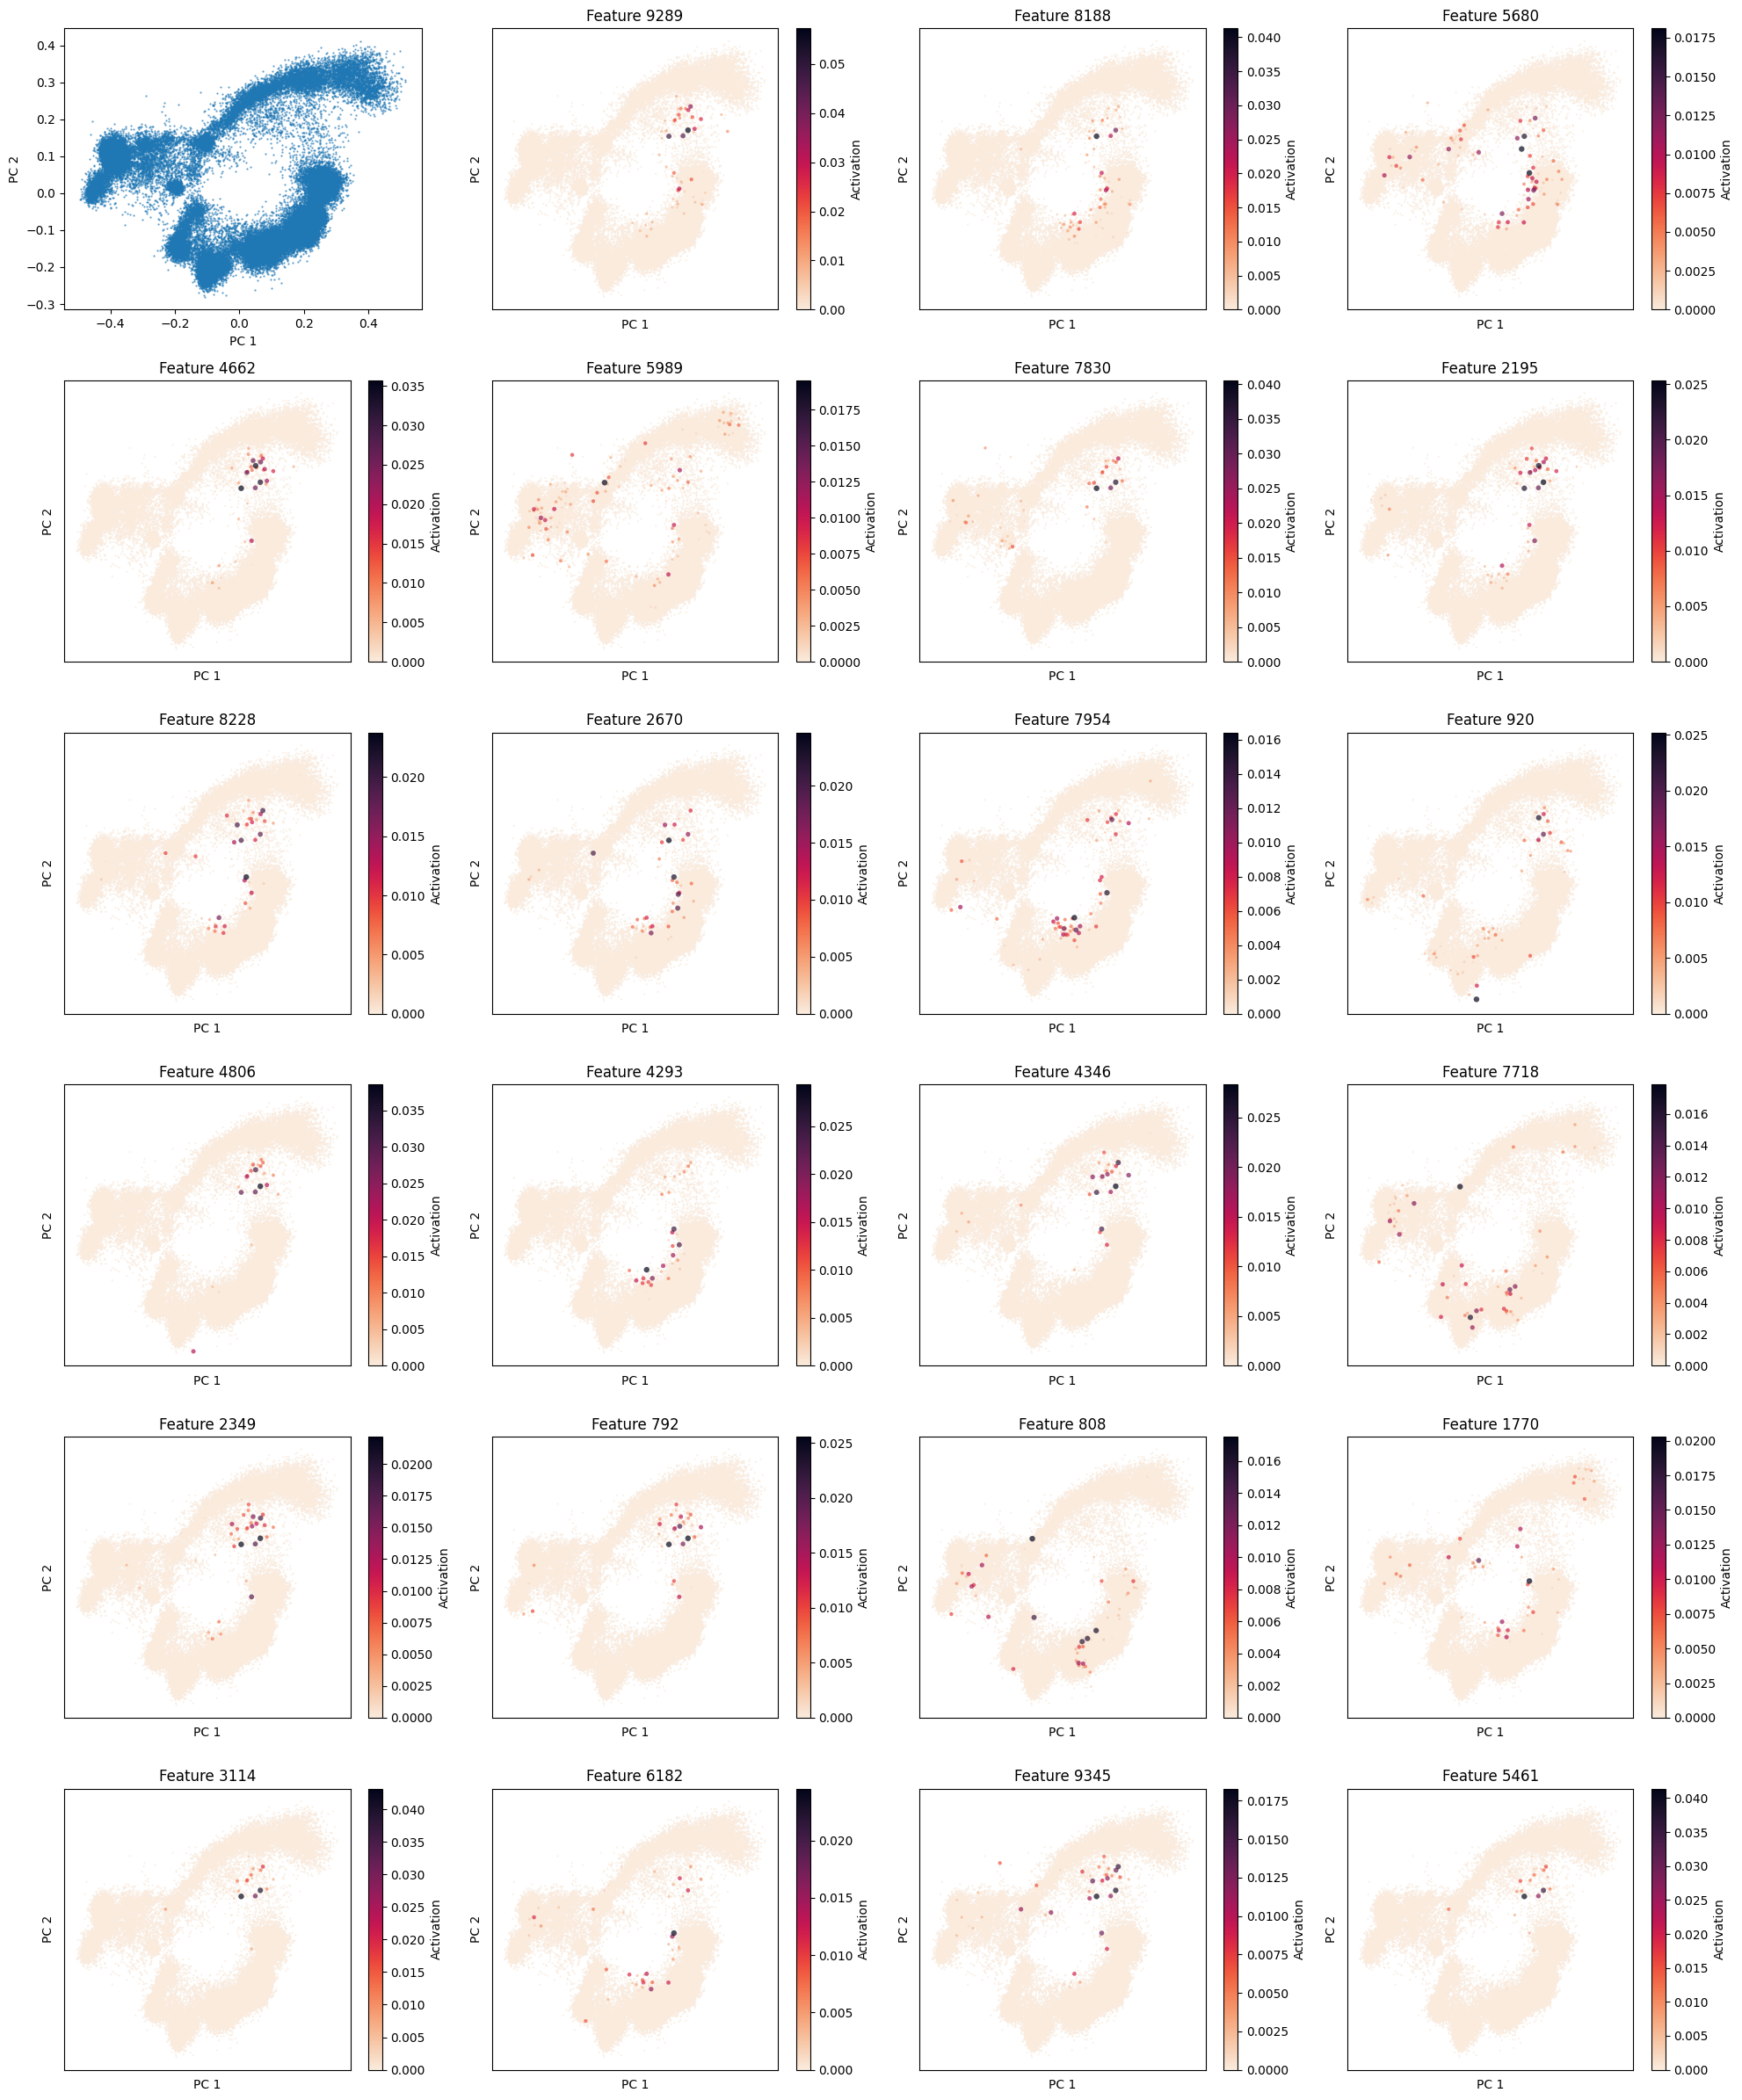

In [9]:
plot_global_by_activ(sort_by='mean')

Too many features to plot
Only plotting the 23 most significant


/tmp/ipykernel_1805030/3896345630.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", s=2, alpha=0.7, ec=None, ax=axs[0, 0], palette=[rocket_r_colors[0], rocket_r_colors[-1]])


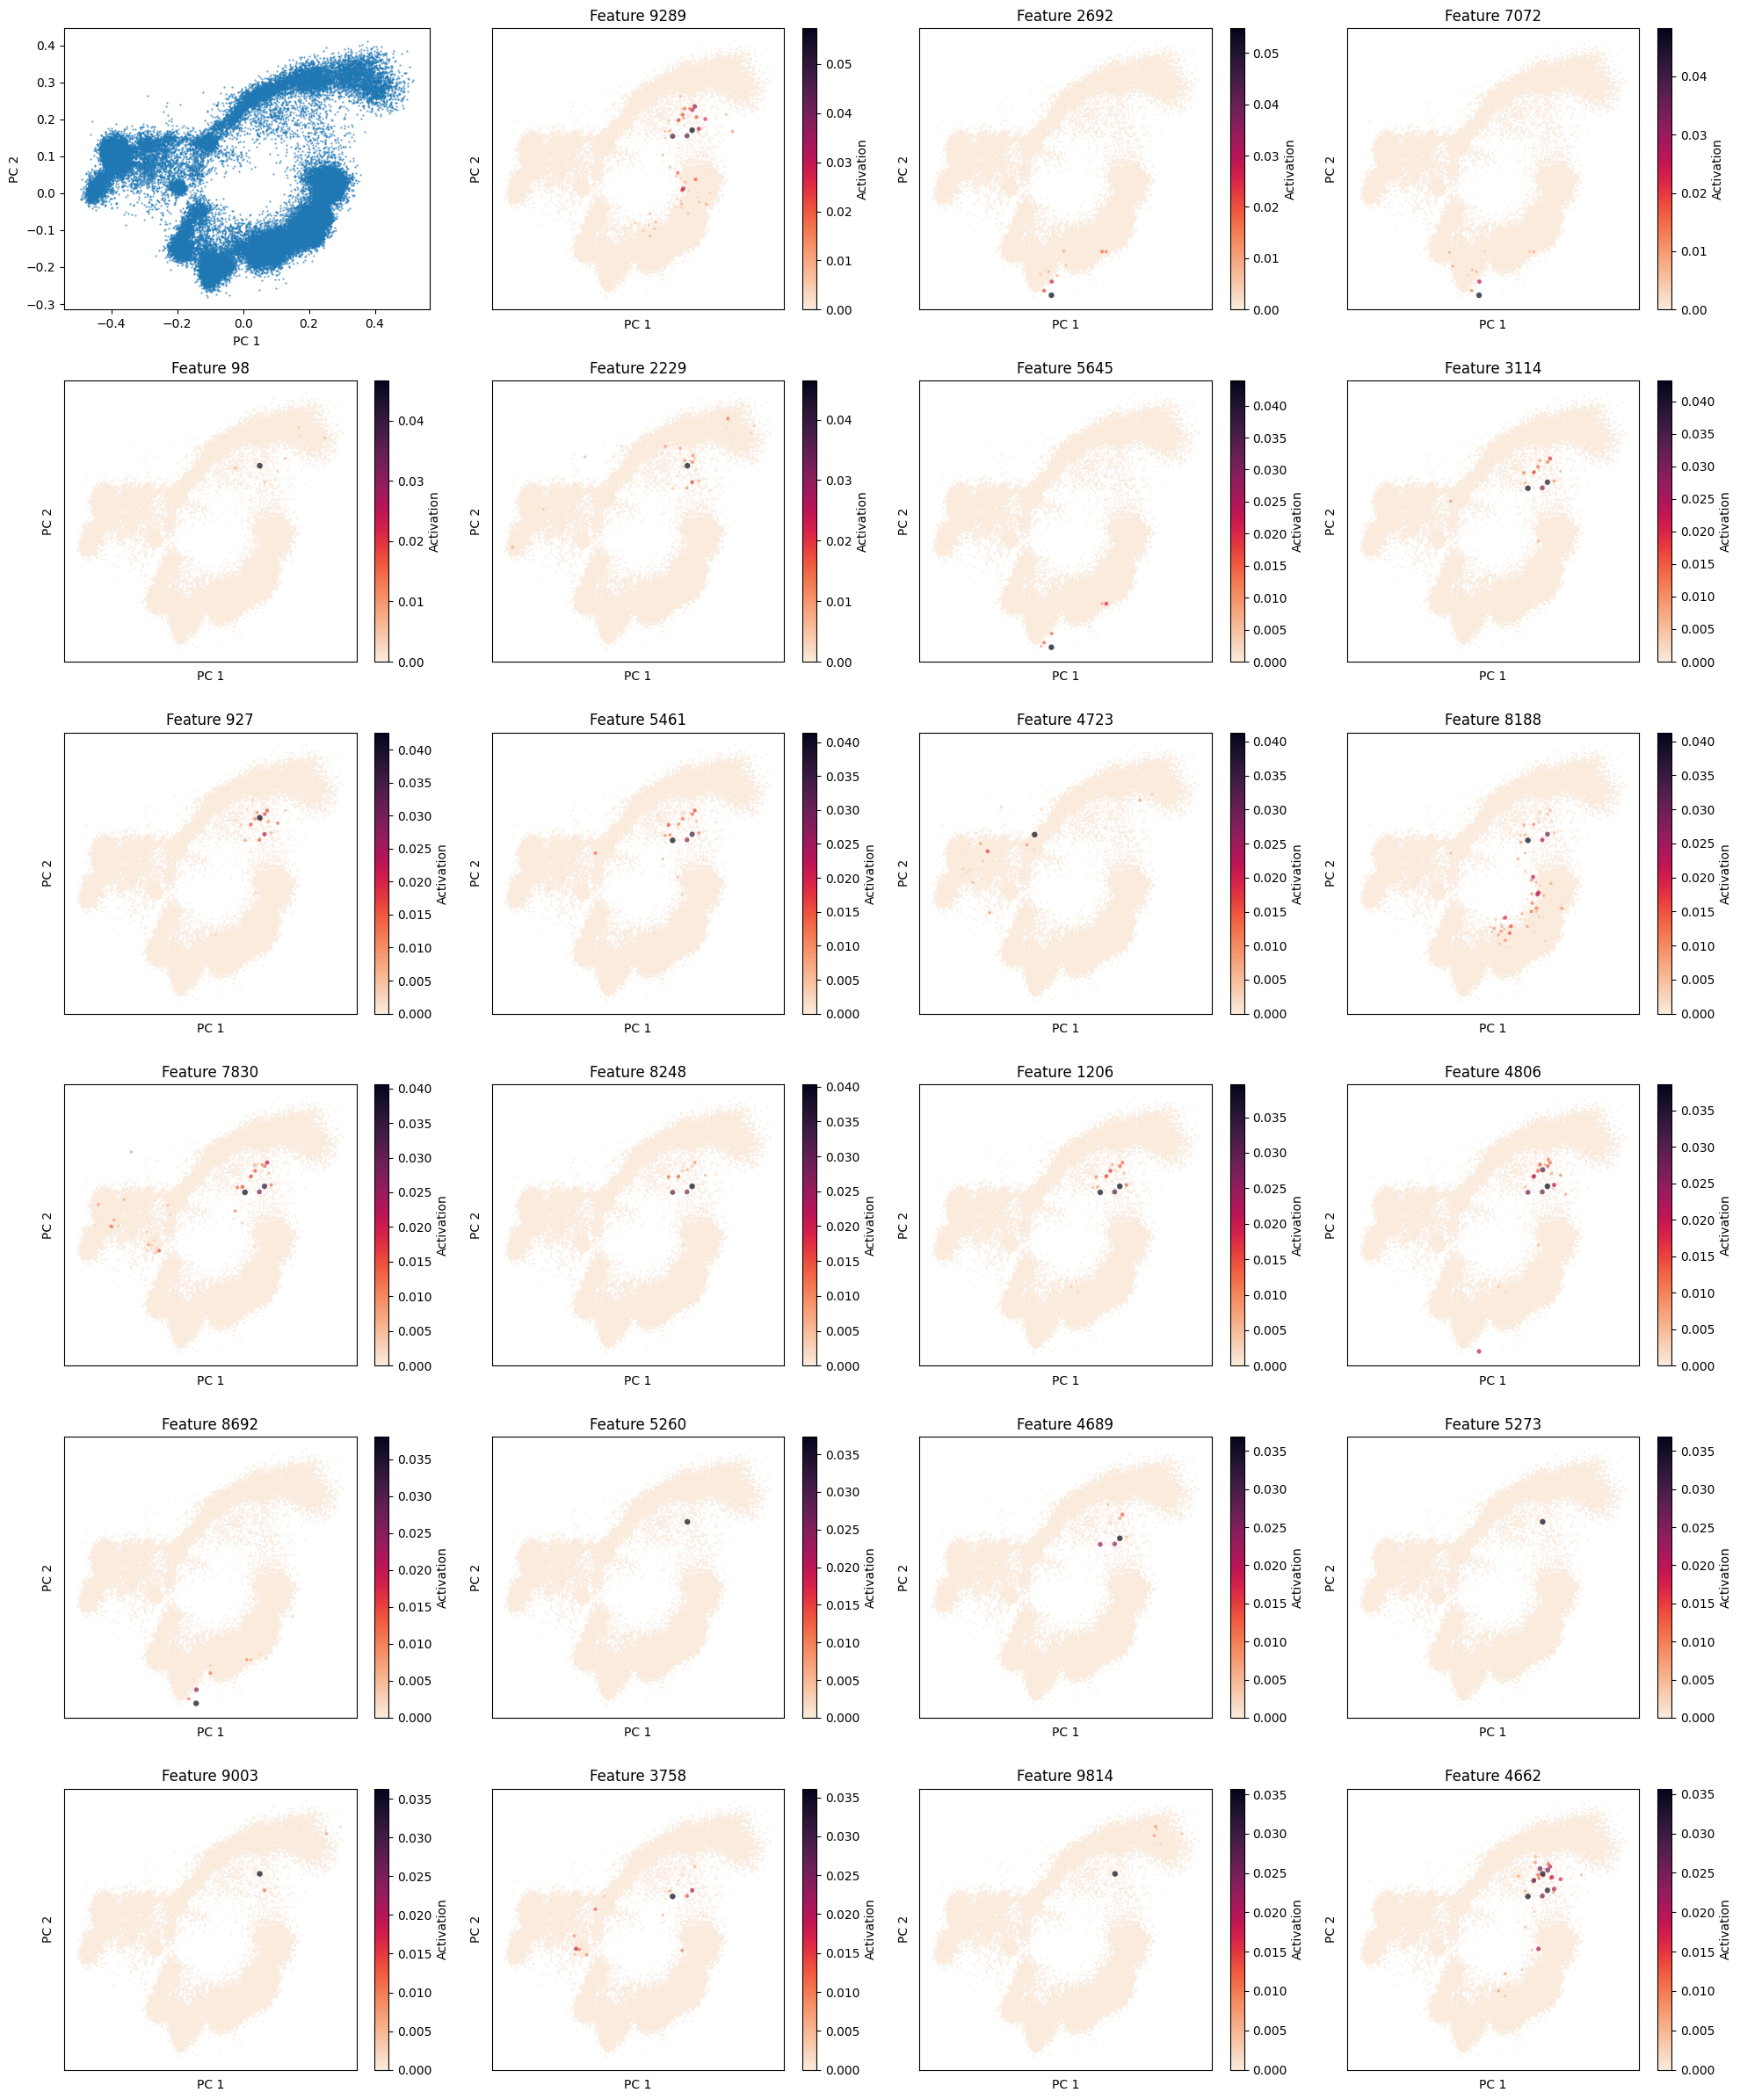

In [10]:
plot_global_by_activ(sort_by='max')

## try to find a feature with high cosine similarity to smoking

In [9]:
activations.shape

torch.Size([56714, 10000])

In [16]:
print(data.obs['DonorSmoker'].unique())

# get a binary tensor for the smoker status
smoker = torch.BoolTensor(data.obs['DonorSmoker'] == 'Smoker')
print('{} many smokers out of {} samples'.format(smoker.sum(), smoker.shape[0]))

['Nonsmoker', 'Smoker']
Categories (2, object): ['Nonsmoker', 'Smoker']
16605 many smokers out of 56714 samples


In [18]:
print(activations.shape, smoker.shape)

cos_sim_smoking = torch.nn.functional.cosine_similarity(activations, smoker.unsqueeze(1), dim=0).detach().cpu()
print(cos_sim_smoking.shape)

torch.Size([56714, 10000]) torch.Size([56714])
torch.Size([10000])


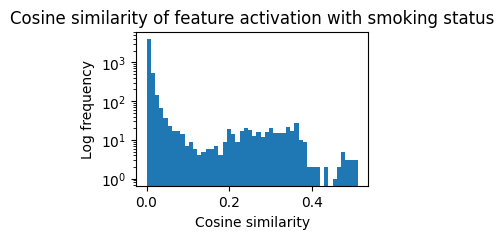

In [25]:
fig = plt.figure(figsize=(3, 2))
plt.hist(cos_sim_smoking[active_features], bins=50)
plt.xlabel('Cosine similarity')
plt.ylabel('Log frequency')
plt.title('Cosine similarity of feature activation with smoking status')
plt.yscale('log')
plt.show()

maximum cosine similarity of feature 5032 with smoking status: 0.5111565589904785
Highest cosine similarities: tensor([0.5112, 0.5105, 0.5048, 0.4980, 0.4955, 0.4949, 0.4898, 0.4879, 0.4836])


/var/folders/c1/jcbft1r124v0ph67_0bnf9nh0000gp/T/ipykernel_72970/158068956.py:33: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=df_celltypes_temp, x="PC 1", y="PC 2", hue='reference', s=2, alpha=0.7, ec=None, ax=axs[0, 0], palette=temp_palette)


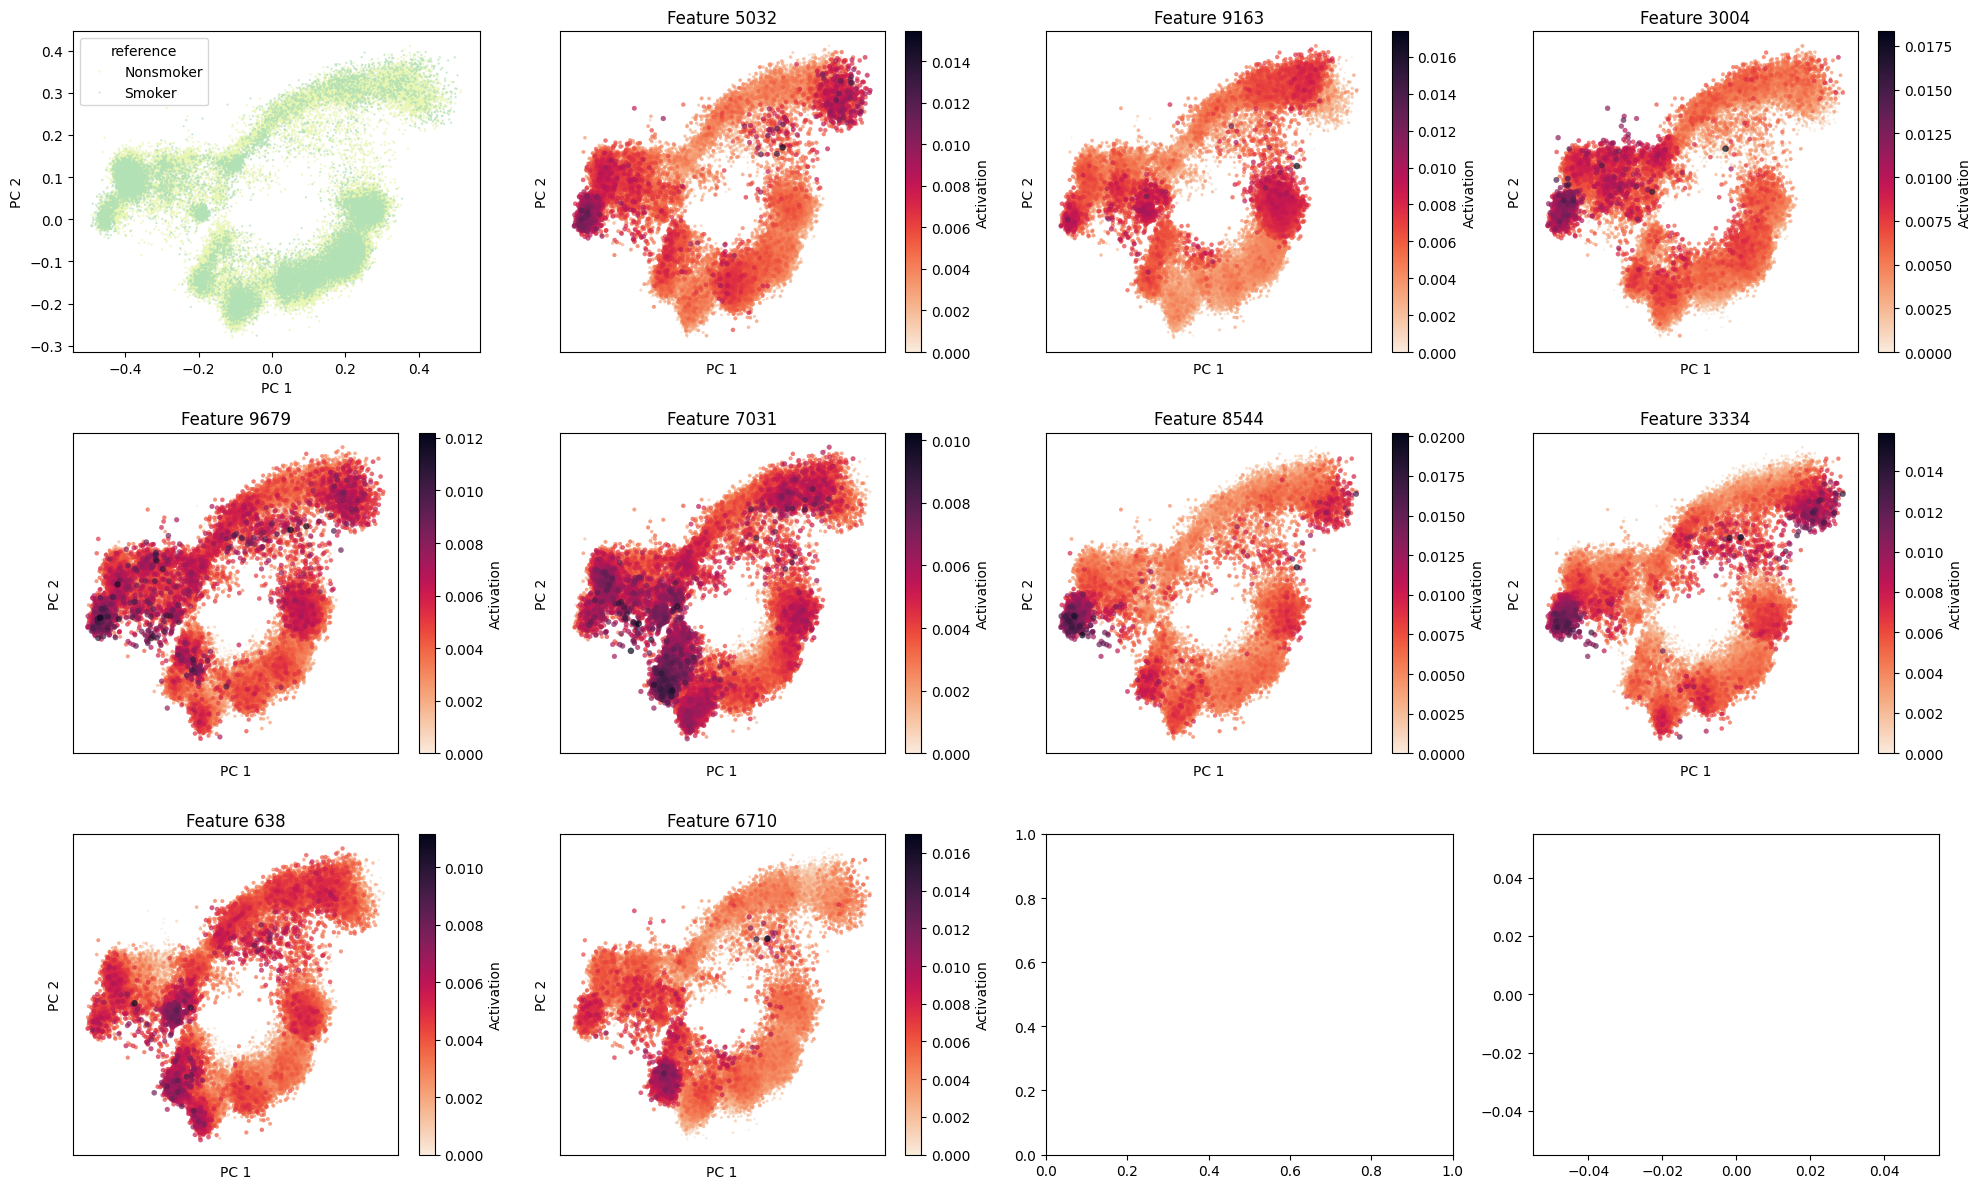

In [42]:
print('maximum cosine similarity of feature {} with smoking status: {}'.format(torch.argmax(cos_sim_smoking).item(), torch.max(cos_sim_smoking).item()))
# sort features by cosine similarity
sorted_features = [x for _, x in sorted(zip(cos_sim_smoking[active_features], active_features), reverse=True)]
print('Highest cosine similarities: {}'.format(cos_sim_smoking[sorted_features[:9]]))

plot_feature_grid(sorted_features[:9], ref=data.obs['DonorSmoker'].values)